#### Part 1: verification against Gala

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os

# add src to sys.path
script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, os.pardir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# packages
from hvs_orbital_kinematics.potentials import MWPotential
from hvs_orbital_kinematics.integrators import leapfrog_step
import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
from gala.units import galactic
import astropy.units as u

# constants
KM_S_TO_KPC_MYR = (u.km / u.s).to(u.kpc / u.Myr)
print("conversion: " + str(KM_S_TO_KPC_MYR))

conversion: 0.001022712165045695


        Use name instead. [gala.dynamics.core]


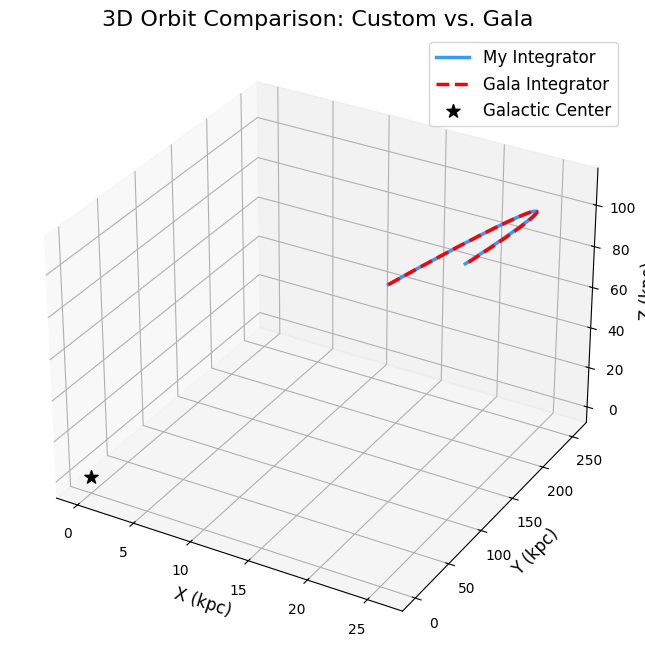

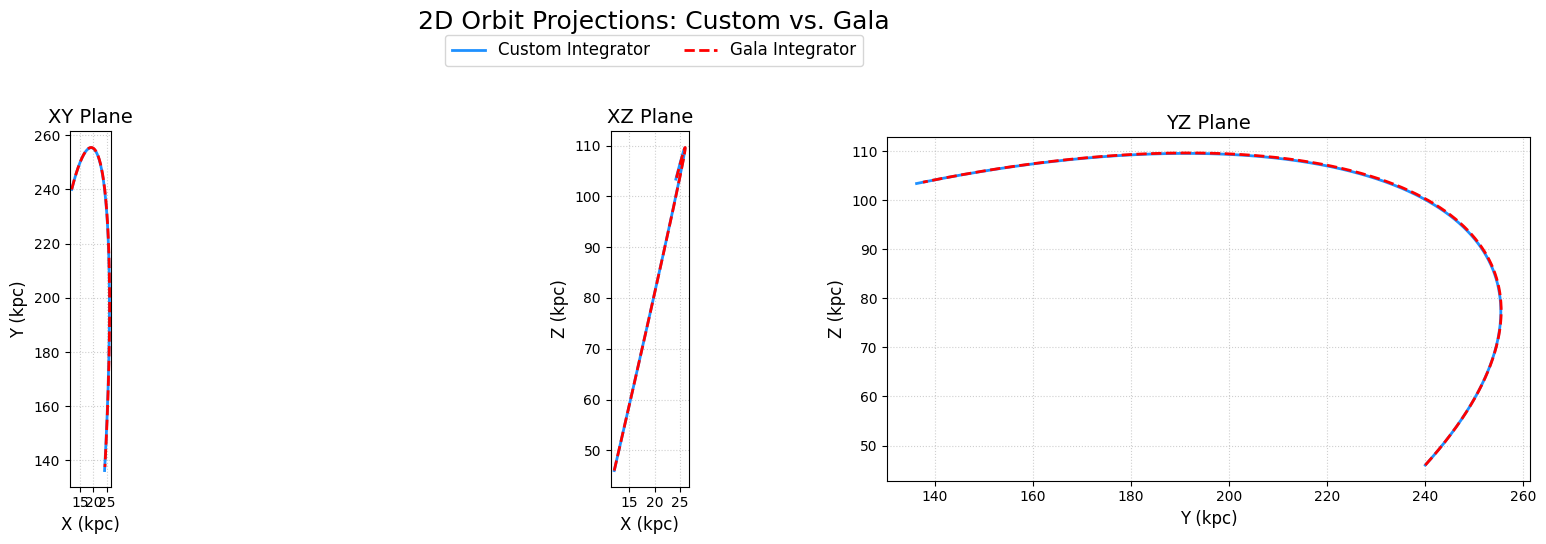

KeyError: 'potential_func'

In [2]:
custom_potential = MWPotential()
gala_potential = gp.MilkyWayPotential()

initial_pos = np.array([12., 240, 46])
initial_vel = np.array([-12, -47,-52])

initial_vel_kpcmyr = initial_vel * KM_S_TO_KPC_MYR

# custom integration parameters
N_STEPS = 5000
DT = -0.5 # Myr
times = np.arange(0, N_STEPS * DT, DT)

# run custom integrator
my_orbit = np.zeros((N_STEPS, 6))
my_orbit[0] = np.concatenate([initial_pos, initial_vel_kpcmyr])

for i in range(1, N_STEPS):
    prev_pos = my_orbit[i-1, :3]
    prev_vel = my_orbit[i-1, 3:]
    new_pos, new_vel = leapfrog_step(prev_pos, prev_vel, DT, custom_potential.get_acceleration)
    my_orbit[i] = np.concatenate([new_pos, new_vel])


# run gala integrator
initial = gd.PhaseSpacePosition(pos=initial_pos * u.kpc,
                                vel=initial_vel * u.km / u.s)
gala_orbit = gala_potential.integrate_orbit(initial, dt=DT * u.Myr,
                                            n_steps=N_STEPS-1,
                                            Integrator=gi.LeapfrogIntegrator)

# plot results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(my_orbit[:, 0], my_orbit[:, 1], my_orbit[:, 2],
        label='My Integrator', lw=2.5, color='dodgerblue', alpha=0.9)

ax.plot(gala_orbit.x, gala_orbit.y, gala_orbit.z,
        label='Gala Integrator', lw=2.5, color='red', linestyle='--')

ax.scatter(0, 0, 0, color='black', s=100, marker='*', label='Galactic Center')

ax.set_xlabel("X (kpc)", fontsize=12)
ax.set_ylabel("Y (kpc)", fontsize=12)
ax.set_zlabel("Z (kpc)", fontsize=12)
ax.set_title("3D Orbit Comparison: Custom vs. Gala", fontsize=16)
ax.legend(fontsize=12)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
fig.suptitle('2D Orbit Projections: Custom vs. Gala', fontsize=18)

custom_label = 'Custom Integrator'
gala_label = 'Gala Integrator'

axes[0].plot(my_orbit[:, 0], my_orbit[:, 1], lw=2, color='dodgerblue', label=custom_label)
axes[0].plot(gala_orbit.x.value, gala_orbit.y.value, lw=2, color='red', linestyle='--', label=gala_label)
axes[0].set_xlabel('X (kpc)', fontsize=12)
axes[0].set_ylabel('Y (kpc)', fontsize=12)
axes[0].set_title('XY Plane', fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid(True, linestyle=':', alpha=0.6)

axes[1].plot(my_orbit[:, 0], my_orbit[:, 2], lw=2, color='dodgerblue')
axes[1].plot(gala_orbit.x.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes[1].set_xlabel('X (kpc)', fontsize=12)
axes[1].set_ylabel('Z (kpc)', fontsize=12)
axes[1].set_title('XZ Plane', fontsize=14)
axes[1].set_aspect('equal', 'box')
axes[1].grid(True, linestyle=':', alpha=0.6)

axes[2].plot(my_orbit[:, 1], my_orbit[:, 2], lw=2, color='dodgerblue')
axes[2].plot(gala_orbit.y.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes[2].set_xlabel('Y (kpc)', fontsize=12)
axes[2].set_ylabel('Z (kpc)', fontsize=12)
axes[2].set_title('YZ Plane', fontsize=14)
axes[2].set_aspect('equal', 'box')
axes[2].grid(True, linestyle=':', alpha=0.6)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout to make room for suptitle and legend
plt.show()

# plot total energy plot
my_KE = 0.5 * np.linalg.norm(my_orbit[:, 3:], axis=1)**2
my_PE = np.array([custom_potential.get_potential_energy(pos) for pos in my_orbit[:, :3]])
my_total_energy = my_KE + my_PE
gala_total_energy = gala_orbit.energy(gala_potential).value
times = np.arange(0, N_STEPS * -DT, -DT)

plt.figure(figsize=(12, 6))
plt.plot(times, my_total_energy, lw=2, color='dodgerblue', label='My Integrator')
plt.plot(gala_orbit.t.value, gala_total_energy, lw=2.5, color='red', linestyle='--', label='Gala Integrator')
plt.title('Total Energy Over Time', fontsize=16)
plt.xlabel('Time (Myr)', fontsize=12)
plt.ylabel(r'Energy ($kpc^2 / Myr^2$)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.show()